In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from preprocessing.feature_extractor import FeatureExtractor

In [2]:
data_dir = "../data/Composer_Dataset"
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
scalar_features, multidimensional_features = FeatureExtractor.extract_features_for_directory(data_dir, composers)

Loading existing features from ../data/Composer_Dataset/extracted_features.pkl


In [3]:
scalar_features.head()

,max_independent_voices,avg_independent_voices,var_independent_voices,avg_simultaneity,var_simultaneity,note_density,avg_note_duration,var_note_duration,initial_tempo,time_signature_numerator,...,perfect_vertical_intervals,vertical_minor_seconds,vertical_thirds,vertical_fifths,vertical_tritones,vertical_octaves,avg_chord_duration,length,file_name,composer
0,4.0,3.899642,0.300477,3.720000,1.020588,6.439026,0.621212,0.296121,143.000038,4.0,...,0.391195,0.000000,0.327044,0.200000,0.045283,0.122013,0.465000,29.999992,042100b_.mid,Bach
1,4.0,3.986667,0.114698,3.600000,1.200000,7.394595,0.526316,0.250579,189.176471,4.0,...,0.400447,0.005220,0.307979,0.168531,0.042506,0.123788,0.321429,25.000000,043100b_.mid,Bach
2,7.0,2.664012,1.617631,2.331998,1.816512,6.292553,0.371665,0.686803,181.905446,4.0,...,0.378734,0.006634,0.291590,0.120602,0.057594,0.158185,0.177695,923.701235,Bwv0564-Toccata-Adagio-and-Fugue.mid,Bach
3,4.0,3.970874,0.168160,3.662222,1.112213,8.775758,0.455801,0.212811,177.509434,4.0,...,0.375205,0.009852,0.312808,0.130542,0.030378,0.115764,0.321875,22.500000,027400b_.mid,Bach
4,4.0,3.917323,0.275394,3.455782,1.371385,5.195127,0.713614,0.442007,153.000153,4.0,...,0.478439,0.002738,0.309377,0.206023,0.016427,0.140999,0.470370,29.333304,026400b_.mid,Bach


In [4]:
print(f"Piano Roll Shape: {multidimensional_features[0]['piano_roll'].shape}")
print(f"Chroma Piano Roll Shape: {multidimensional_features[0]['chroma_piano_roll'].shape}")
print(f"Pitch Class Histogram Shape: {multidimensional_features[0]['pitch_class_histogram'].shape}")
print(f"Pitch Class Transition Matrix Shape: {multidimensional_features[0]['pitch_class_transition_matrix'].shape}")

Piano Roll Shape: (128, 299)
Chroma Piano Roll Shape: (12, 299)
Pitch Class Histogram Shape: (12,)
Pitch Class Transition Matrix Shape: (12, 12)


In [5]:
scalar_features = scalar_features.drop('file_name', axis=1)
x = scalar_features.drop('composer', axis=1)
y = scalar_features['composer']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [6]:
classifier = HistGradientBoostingClassifier(random_state=1)
classifier.fit(x_train, y_train)

HistGradientBoostingClassifier(random_state=1)

In [7]:
y_pred = classifier.predict(x_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

        Bach       0.91      0.98      0.94       209
   Beethoven       0.85      0.67      0.75        43
      Chopin       0.97      0.82      0.89        34
      Mozart       0.71      0.66      0.68        41

    accuracy                           0.88       327
   macro avg       0.86      0.78      0.82       327
weighted avg       0.88      0.88      0.88       327



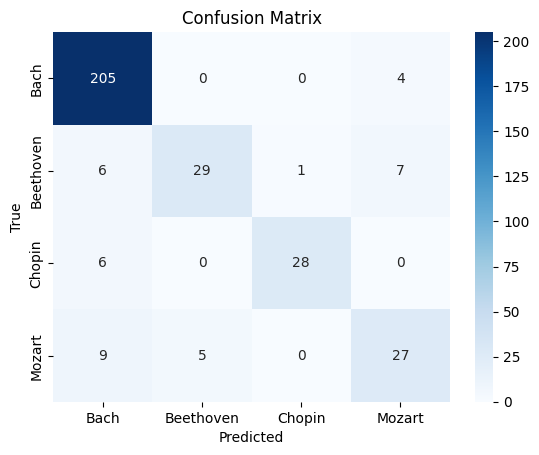

In [8]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## CNN Example

### Train Val Test Split

In [9]:
train_split = 0.8  # ratio of all data to use for training
val_test_split = 0.5  # ratio of holdout data to use for test set

x = multidimensional_features
y = scalar_features['composer']

y = label_encoder.transform(y)

x_train, x_holdout, y_train, y_holdout = train_test_split(x, y, test_size=(1 - train_split), random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_holdout, y_holdout, test_size=val_test_split, random_state=1)

### Chunk Into Sequences

In [10]:
def chunk_sequences(X_in, y_in, feature, sequence_length=100):
    X_out = []
    y_out = []

    # make sequences split along the time axis
    for i in range(len(X_in)):
        for j in range(0, len(X_in[i][feature][1]) - sequence_length, sequence_length):
            X_out.append(X_in[i][feature][:, j:j + sequence_length])
            y_out.append(y_in[i])

    return X_out, y_out

In [11]:
sequence_length = 100  # Assuming frequency of 10 Hz
feature_set = 'chroma_piano_roll'

X_train_seq, y_train_seq = chunk_sequences(x_train, y_train, feature_set, sequence_length)
X_val_seq, y_val_seq = chunk_sequences(x_val, y_val, feature_set, sequence_length)
X_test_seq, y_test_seq = chunk_sequences(x_test, y_test, feature_set, sequence_length)

In [12]:
print("Training Set Size: ", len(X_train_seq))
print("Validation Set Size: ", len(X_val_seq))
print("Test Set Size: ", len(X_test_seq))

Training Set Size:  31937
Validation Set Size:  3596
Test Set Size:  3519


### Make Dataloader

In [13]:
class PianoRollDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32) 
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X, y

In [28]:
batch_size = 8

# Set the seed for the training dataset shuffle
seed = 42
torch.manual_seed(seed)

train_dataset = PianoRollDataset(X_train_seq, y_train_seq)
val_dataset = PianoRollDataset(X_val_seq, y_val_seq)
test_dataset = PianoRollDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define CNN

In [29]:
class PianoRollCNN(nn.Module):
    def __init__(self):
        super(PianoRollCNN, self).__init__()
        # Conv1d layers: input channels = 12, height = 1, width = 50
        self.conv1 = nn.Conv1d(12, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 25, 128)
        self.fc2 = nn.Linear(128, 4)  # Output of 4 classes (composers)

    def forward(self, x):
        x = x.squeeze(2) # This can potentially be removed if the input is reshaped correctly in the dataloader
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = PianoRollCNN()

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    report_interval = 100
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % report_interval == (report_interval - 1):
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / report_interval:.3f}')
            running_loss = 0.0  # Reset running loss

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')

print('Finished Training')


[Epoch 1, Batch 100] loss: 2.698
[Epoch 1, Batch 200] loss: 1.235
[Epoch 1, Batch 300] loss: 1.215
[Epoch 1, Batch 400] loss: 1.221
[Epoch 1, Batch 500] loss: 1.228
[Epoch 1, Batch 600] loss: 1.219
[Epoch 1, Batch 700] loss: 1.188
[Epoch 1, Batch 800] loss: 1.138
[Epoch 1, Batch 900] loss: 1.156
[Epoch 1, Batch 1000] loss: 1.183
[Epoch 1, Batch 1100] loss: 1.166
[Epoch 1, Batch 1200] loss: 1.173
[Epoch 1, Batch 1300] loss: 1.125
[Epoch 1, Batch 1400] loss: 1.168
[Epoch 1, Batch 1500] loss: 1.199
[Epoch 1, Batch 1600] loss: 1.149
[Epoch 1, Batch 1700] loss: 1.105
[Epoch 1, Batch 1800] loss: 1.192
[Epoch 1, Batch 1900] loss: 1.092
[Epoch 1, Batch 2000] loss: 1.131
[Epoch 1, Batch 2100] loss: 1.108
[Epoch 1, Batch 2200] loss: 1.090
[Epoch 1, Batch 2300] loss: 1.095
[Epoch 1, Batch 2400] loss: 1.121
[Epoch 1, Batch 2500] loss: 1.129
[Epoch 1, Batch 2600] loss: 1.102
[Epoch 1, Batch 2700] loss: 1.109
[Epoch 1, Batch 2800] loss: 1.054
[Epoch 1, Batch 2900] loss: 1.105
[Epoch 1, Batch 3000] l

### Evaluate Performance

In [32]:
model.eval()

all_labels = []
all_predictions = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Store true and predicted labels
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Compute the classification report
report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

        Bach       0.81      0.89      0.85      1619
   Beethoven       0.51      0.58      0.54       901
      Chopin       0.80      0.33      0.47       518
      Mozart       0.30      0.30      0.30       481

    accuracy                           0.65      3519
   macro avg       0.60      0.53      0.54      3519
weighted avg       0.66      0.65      0.64      3519

